In [1]:
# Installing package
# !pip install --quiet --user git+https://github.com/DifferentiableUniverseInitiative/JaxPM.git
!pip install --quiet --user jax_cosmo numpyro chainconsumer

  Preparing metadata (setup.py) ... done


In [1]:
import os
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='.99'

In [2]:
%pylab inline
import h5py
import jax
import jax.numpy as jnp
import jax_cosmo as jc
from jax_cosmo.scipy.integrate import simps
import astropy.units as u
from chainconsumer import ChainConsumer
import numpyro
import numpyro.distributions as dist

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [3]:
#@title Run Me

# This module contains utility functions to run a forward simulation using an LPT lightcone
import jax
import jax.numpy as jnp

import jax_cosmo as jc

import numpyro
import numpyro.distributions as dist

from jax.experimental.ode import odeint
from jaxpm.pm import lpt, make_ode_fn, pm_forces, growth_factor, growth_rate, dGfa
from jaxpm.kernels import fftk
from jaxpm.lensing import density_plane

from jaxpm.painting import cic_paint, cic_read, cic_paint_2d
from jaxpm.kernels import gradient_kernel, laplace_kernel, longrange_kernel
from jaxpm.utils import gaussian_smoothing

from jax.scipy.ndimage import map_coordinates
from jaxpm.utils import gaussian_smoothing
import jax_cosmo.constants as constants

def linear_field(mesh_shape, box_size, pk, field):
  """
    Generate initial conditions.
    """
  kvec = fftk(mesh_shape)
  kmesh = sum(
      (kk / box_size[i] * mesh_shape[i])**2 for i, kk in enumerate(kvec))**0.5
  pkmesh = pk(kmesh) * (mesh_shape[0] * mesh_shape[1] * mesh_shape[2]) / (
      box_size[0] * box_size[1] * box_size[2])

  field = jnp.fft.rfftn(field) * pkmesh**0.5
  field = jnp.fft.irfftn(field)
  return field

def lpt_lightcone(cosmo, initial_conditions, positions, a, mesh_shape):
    """
    Computes first order LPT displacement
    """
    initial_force = pm_forces(positions, delta=initial_conditions).reshape(mesh_shape+[3])
    a = jnp.atleast_1d(a)
    dx = growth_factor(cosmo, a).reshape([1,1,-1,1]) * initial_force
    p = (a**2 * growth_rate(cosmo, a) * jnp.sqrt(jc.background.Esqr(cosmo, a))).reshape([1,1,-1,1]) * dx
    f = (a**2 * jnp.sqrt(jc.background.Esqr(cosmo, a)) * dGfa(cosmo, a)).reshape([1,1,-1,1]) * initial_force
    return dx.reshape([-1,3]), p.reshape([-1,3]), f.reshape([-1,3])

def convergence_Born(cosmo,
                     density_planes,
                     r,
                     a,
                     dx,
                     dz,
                     coords,
                     z_source):
  """
  Compute the Born convergence
  Args:
    cosmo: `Cosmology`, cosmology object.
    density_planes: list of dictionaries (r, a, density_plane, dx, dz), lens planes to use
    coords: a 3-D array of angular coordinates in radians of N points with shape [batch, N, 2].
    z_source: 1-D `Tensor` of source redshifts with shape [Nz] .
    name: `string`, name of the operation.
  Returns:
    `Tensor` of shape [batch_size, N, Nz], of convergence values.
  """
  # Compute constant prefactor:
  constant_factor = 3 / 2 * cosmo.Omega_m * (constants.H0 / constants.c)**2
  # Compute comoving distance of source galaxies
  r_s = jc.background.radial_comoving_distance(cosmo, 1 / (1 + z_source))

  convergence = 0
  n_planes = len(r)

  def scan_fn(carry, i):
    density_planes, a, r = carry

    p = density_planes[:,:,i]
    density_normalization = dz * r[i] / a[i]
    p = (p - p.mean()) * constant_factor * density_normalization

    # Interpolate at the density plane coordinates
    im = map_coordinates(p,
                         coords * r[i] / dx - 0.5,
                         order=1, mode="wrap")

    return carry, im * jnp.clip(1. - (r[i] / r_s), 0, 1000).reshape([-1, 1, 1])

  _, convergence = jax.lax.scan(scan_fn, (density_planes, a, r), jnp.arange(n_planes))

  return convergence.sum(axis=0)

In [4]:
from scipy.stats import norm
z = linspace(0, 2.5, 1000)

nz_shear = [jc.redshift.kde_nz(z,
                               norm.pdf(z, loc=z_center, scale=0.12) ,
                               bw=0.01, zmax=2.5, gals_per_arcmin2=g )
                for z_center, g in zip([0.5, 1., 1.5, 2.], [7,8.5, 7.5, 7])]


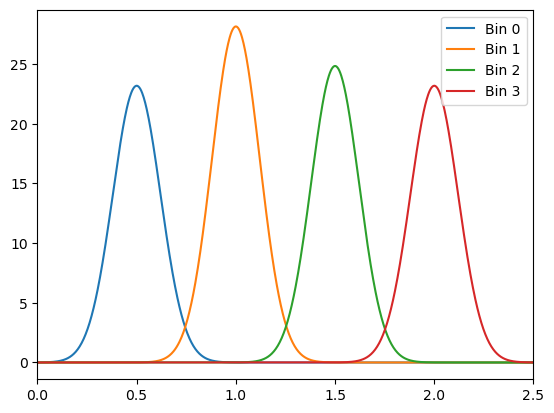

In [5]:
for i in range(4):
  plot(z, nz_shear[i](z)*nz_shear[i].gals_per_arcmin2, color='C%d'%i, label="Bin %d"%i)
legend()
xlim(0,2.5);

In [6]:
box_size=[1000., 1000., 4500.] # In Mpc/h
nc = [64, 64, 128]             # Number of pixels
field_size = 16                # Size of the lensing field in degrees
field_npix = 64                # Number of pixels in the lensing field
sigma_e = 0.3                  # Standard deviation of galaxy ellipticities
galaxy_density = 30./4         # Galaxy density per arcmin^2, per redshift bin

@jax.jit
def forward_model(Omega_c, sigma_8, initial_conditions):
  """
  This function defines the top-level forward model for our observations
  """
  # Sampling cosmological parameters and defines cosmology
  Omega_b = 0.04
  h = 0.7
  n_s = 0.96
  w0 = -1
  cosmo = jc.Cosmology(Omega_c=Omega_c, sigma8=sigma_8, Omega_b=Omega_b,
                       h=h, n_s=n_s, w0=w0, Omega_k=0., wa=0.)

  # Create a small function to generate the matter power spectrum
  k = jnp.logspace(-4, 1, 128)
  pk = jc.power.linear_matter_power(cosmo, k)
  pk_fn = lambda x: jc.scipy.interpolate.interp(x.reshape([-1]), k, pk).reshape(x.shape)

  # Create initial conditions
  lin_field = linear_field(nc, box_size, pk_fn, initial_conditions)

  # Create particles
  particles = jnp.stack(jnp.meshgrid(*[jnp.arange(s) for s in nc]),axis=-1).reshape([-1,3])

  # Compute the scale factor that corresponds to each slice of the volume
  r = (jnp.arange(nc[-1]) + 0.5)*box_size[-1]/nc[-1]
  a = jc.background.a_of_chi(cosmo, r)

  cosmo = jc.Cosmology(Omega_c=Omega_c, sigma8=sigma_8, Omega_b=Omega_b,
                       h=h, n_s=n_s, w0=w0, Omega_k=0., wa=0.)
  # Initial displacement
  dx, p, f = lpt_lightcone(cosmo, lin_field, particles, a, nc)

  # Paint the particles on a new mesh
  lightcone = cic_paint(jnp.zeros(nc),  particles+dx)
  dx = box_size[0] / nc[0]
  dz = box_size[-1] / nc[-1]

  # Defining the coordinate grid for lensing map
  xgrid, ygrid = np.meshgrid(np.linspace(0, field_size, field_npix, endpoint=False), # range of X coordinates
                             np.linspace(0, field_size, field_npix, endpoint=False)) # range of Y coordinates
  coords = jnp.array((np.stack([xgrid, ygrid], axis=0)*u.deg).to(u.rad))

  # Generate convergence maps by integrating over nz and source planes
  convergence_maps = [simps(lambda z: nz(z).reshape([-1,1,1]) *
                              convergence_Born(cosmo, lightcone, r,a, dx, dz, coords, z), 0.01, 2.5, N=32)
                      for nz in nz_shear]
  return convergence_maps, lightcone


def model():
  """
  This function defines the top-level forward model for our observations
  """

  # Sampling initial conditions
  initial_conditions = numpyro.sample(
      'initial_conditions',
      dist.Normal(jnp.zeros(nc), jnp.ones(nc)))

  # Sampling cosmological parameters and defines cosmology
  Omega_c = numpyro.sample('omega_c', dist.Uniform(0.1, 0.7))
  sigma_8 = numpyro.sample('sigma_8', dist.Uniform(0.5, 1.6))

  convergence_maps, _ = forward_model(Omega_c, sigma_8, initial_conditions)

  # Apply noise to the maps (this defines the likelihood)
  observed_maps = [numpyro.sample('kappa_%d'%i,
                                  dist.Normal(k, sigma_e/jnp.sqrt(galaxy_density*(field_size*60/field_npix)**2)))
                   for i,k in enumerate(convergence_maps)]

  return observed_maps

Once the model is defined, it needs to be seeded, and then can be ran and traced if one wants to access all the stochastic variables.

In [7]:
# condition the model on a given set of parameters
fiducial_model = numpyro.handlers.condition(model, {'omega_c': 0.3175,
                                                    'sigma_8': 0.8})

# sample a mass map and save corresponding true parameters
model_trace = numpyro.handlers.trace(numpyro.handlers.seed(fiducial_model, jax.random.PRNGKey(1234))).get_trace()

/home/francois/.local/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/tmp/ipykernel_61157/1938900258.py:30: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  kmesh = sum(


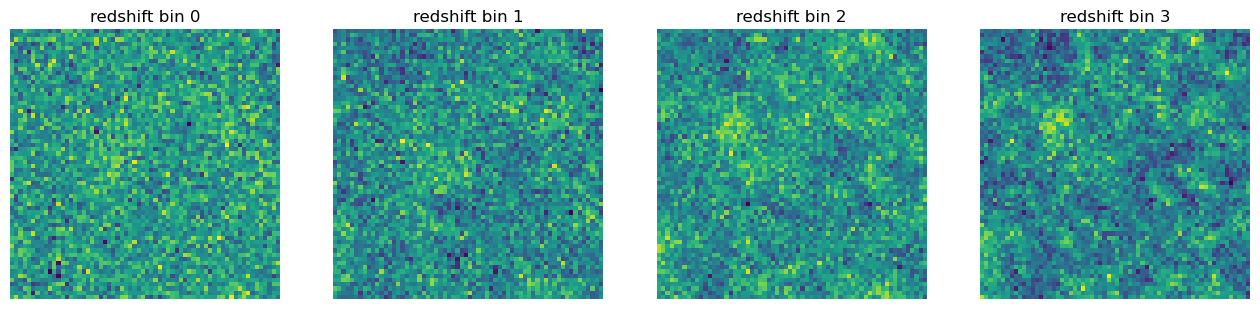

In [8]:
# plotting the trace
from scipy.ndimage import gaussian_filter

figure(figsize=[16,4])
for i in range(4):
    subplot(1,4,i+1)
    title('redshift bin %d'%i)
    imshow(gaussian_filter(model_trace['kappa_%d'%i]['value'],0.))
    axis('off')

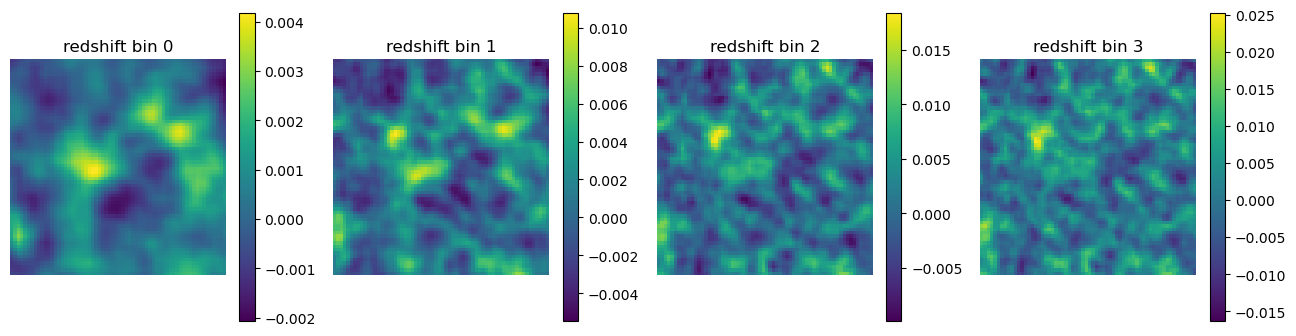

In [9]:
# plotting the trace
figure(figsize=[16,4])
for i in range(4):
    subplot(1,4,i+1)
    title('redshift bin %d'%i)
    imshow(model_trace['kappa_%d'%i]['fn'].mean)
    colorbar()
    axis('off')

In [10]:
observed_map = jnp.stack([model_trace['kappa_0']['value'],
                          model_trace['kappa_1']['value'],
                          model_trace['kappa_2']['value'],
                          model_trace['kappa_3']['value']], axis=-1)

In [11]:
# Adding code to draw many maps
from tqdm import tqdm
seeded_model = numpyro.handlers.seed(model, jax.random.PRNGKey(42))

params = []
maps = []
for i in tqdm(range(100_000)):
    model_trace = numpyro.handlers.trace(seeded_model).get_trace()
    kmap = np.stack([model_trace['kappa_0']['value'],
                      model_trace['kappa_1']['value'],
                      model_trace['kappa_2']['value'],
                      model_trace['kappa_3']['value']], axis=-1).astype('float32')
    params.append(np.stack([model_trace['omega_c']['value'], model_trace['sigma_8']['value']]).astype('float32'))
    maps.append(kmap)
    del model_trace

params = np.stack(params)
maps = np.stack(maps)

  0%|                                                                                                                            | 0/100000 [00:00<?, ?it/s]/tmp/ipykernel_61157/1938900258.py:30: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  kmesh = sum(
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [14:35<00:00, 114.25it/s]


In [13]:
# # export the maps
# np.savez('PorqueresModel.npz', params.astype('float32'), maps.astype('float32'))

In [12]:
import haiku as hk
import optax

In [13]:
master_seed = hk.PRNGSequence(42)

In [14]:
class Compressor(hk.Module):
  """This is a NN that predicts the score."""
  def __call__(self, x):
    net_x = hk.Conv2D(32, 3, 2)(x) # in 32
    net_x = jax.nn.leaky_relu(net_x)
    net_x = hk.Conv2D(64, 3, 2)(net_x) # in 16
    net_x = jax.nn.leaky_relu(net_x)
    net_x = hk.Conv2D(128, 3, 2)(net_x)# in 8
    net_x = jax.nn.leaky_relu(net_x)
    net_x = hk.AvgPool(16,8,'SAME')(net_x) # in 2
    net_x = hk.Flatten()(net_x)

    # Bottleneck
    net_x = hk.Linear(2)(net_x)

    return net_x.squeeze()

In [15]:
compressor = hk.without_apply_rng(hk.transform(lambda x : Compressor()(x)))
rng_seq = hk.PRNGSequence(12)
params_compressor = compressor.init(next(rng_seq), jnp.zeros([1,64,64,4]))

In [25]:
def loss_fn(params, batch):
  out = compressor.apply(params, batch[0]) # Here we extract the grad of the model
  return jnp.mean(jnp.sum((out - batch[1])**2, axis=1))

@jax.jit
def update(params, opt_state, batch):
    """Single SGD update step."""
    loss, grads = jax.value_and_grad(loss_fn)(params, batch)
    updates, new_opt_state = optimizer.update(grads, opt_state)
    new_params = optax.apply_updates(params, updates)
  
    return loss, new_params, new_opt_state

In [17]:
from tqdm import tqdm
losses = []
master_seed = hk.PRNGSequence(0)

In [24]:
learning_rate=0.0002
optimizer = optax.adam(learning_rate)
opt_state = optimizer.init(params_compressor)

In [43]:
it = 10000

for step in tqdm(range(it)):
  inds = np.random.randint(0, 90_000, 128)
 
  x = maps[inds]
  y = params[inds]
  batch = [x, y]
  l, params_compressor, opt_state = update(params_compressor, opt_state, batch)
  losses.append(l)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:18<00:00, 543.51it/s]


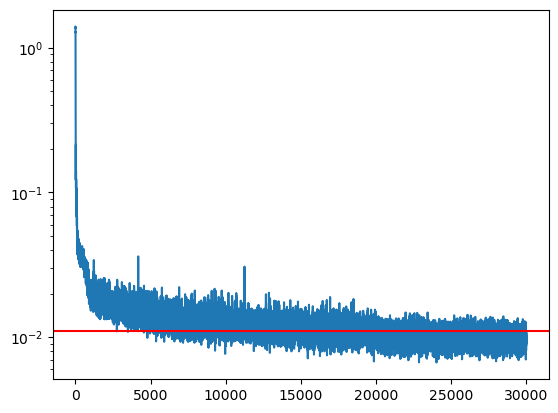

In [27]:
reg = compressor.apply(params_compressor, maps[90_000:91_024])
l = jnp.mean(jnp.sum((reg - params[90_000:91_024])**2, axis=1))
semilogy(array(losses))
axhline(l, color='red')

In [28]:
reg = compressor.apply(params_compressor, maps[50_000:50_512])

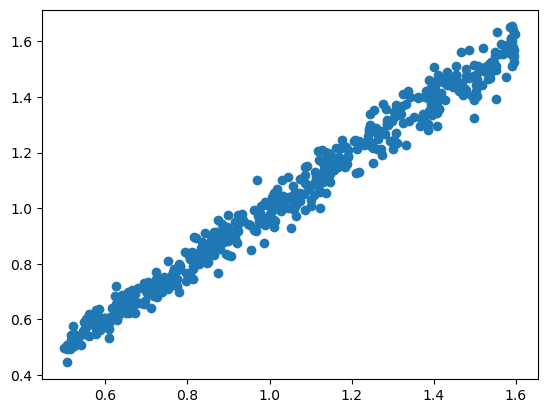

In [29]:
scatter(params[50_000:50_512,1], reg[:,1])

In [31]:
# And compressing all the examples between 50_000 and 60_000
dset_compressed = []
for i in range(10):
    x_test = maps[90_000 + i*1000:90_000 + (i+1)*1000]
    pred = compressor.apply(params_compressor, x_test)
    dset_compressed.append(pred)
dset_compressed = jnp.concatenate(dset_compressed, axis=0)

In [32]:
# Alright, cool, let's get some posteriors
from sbi.inference import SNLE, SNPE_A, prepare_for_sbi, simulate_for_sbi
from sbi import utils as utils
import torch

2024-02-07 00:26:33.782236: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-07 00:26:33.782254: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-07 00:26:33.793980: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [33]:
prior = utils.BoxUniform(low=torch.tensor([0.1, 0.5]), high=torch.tensor([0.7, 1.6]))
inference = SNPE_A(prior=prior)

In [35]:
inference = inference.append_simulations(torch.tensor(params[90_000:100_000,:2]), 
                                         torch.tensor(np.array(dset_compressed)))

# Train the density estimator
density_estimator = inference.train()

 Neural network successfully converged after 50 epochs.

In [36]:
true_fake =  compressor.apply(params_compressor, observed_map[jnp.newaxis] )

In [37]:
posterior = inference.build_posterior(density_estimator)
posterior_samples = posterior.sample((50000,), x=np.array(true_fake).squeeze())

Drawing 50000 posterior samples:   0%|          | 0/50000 [00:00<?, ?it/s]

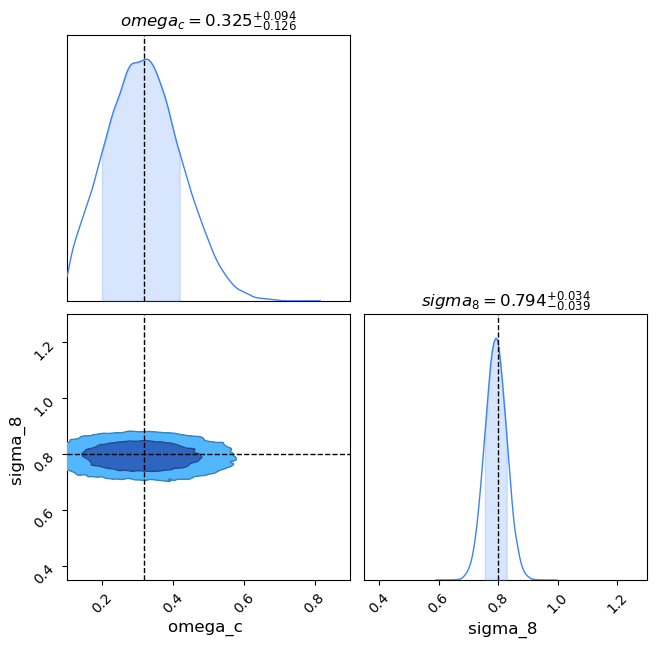

In [39]:
from chainconsumer import Chain, Truth, PlotConfig
import pandas as pd
s = posterior_samples.cpu().detach().numpy()
df = pd.DataFrame({'omega_c': s[:,0],
                   'sigma_8': s[:,1]})

c = ChainConsumer()
c.add_chain(Chain(samples=df, name='Posterior'))
c.add_truth(Truth(location={"omega_c": 0.3175, "sigma_8": 0.8}))
c.set_plot_config(PlotConfig( extents={"omega_c": (0.1,0.9), "sigma_8": (0.35,1.3)}))
fig = c.plotter.plot(figsize="column")

In [41]:
# loading the chain from the sampler
data = np.load('PorqueresModel (1).npz')

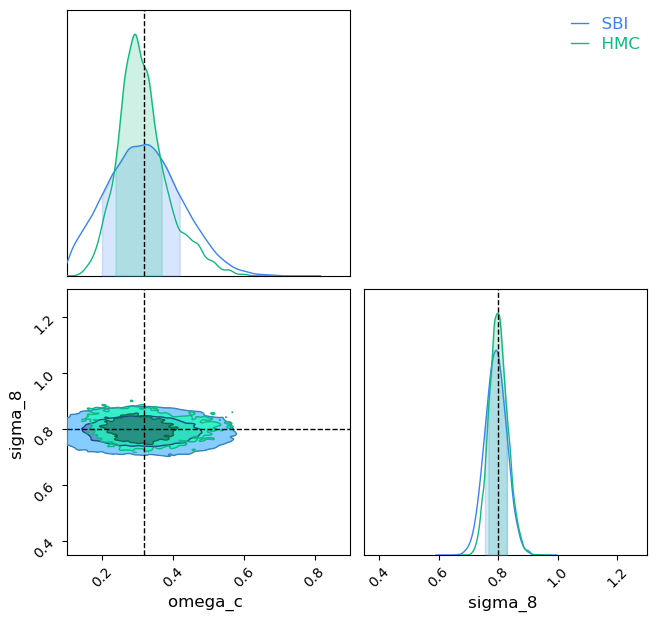

In [42]:
df2 = pd.DataFrame({'omega_c': data['omega_c'],
                   'sigma_8': data['sigma_8']})

c = ChainConsumer()
c.add_chain(Chain(samples=df, name='SBI'))
c.add_chain(Chain(samples=df2, name='HMC'))
c.add_truth(Truth(location={"omega_c": 0.3175, "sigma_8": 0.8}))
c.set_plot_config(PlotConfig( extents={"omega_c": (0.1,0.9), "sigma_8": (0.35,1.3)}))
fig = c.plotter.plot(figsize="column")

In [24]:
import numpyro
from numpyro.handlers import seed, trace, condition, reparam
from numpyro.infer.reparam import LocScaleReparam, TransformReparam
import numpyro.distributions as dist
from functools import partial

def config(x):
    if type(x['fn']) is dist.TransformedDistribution:
        return TransformReparam()
    elif type(x['fn']) is dist.Normal and ('decentered' not in x['name']) and ('kappa' not in x['name']) and ('cond' not in x['name']):
        return LocScaleReparam(centered=0)
    else:
        return None

In [25]:
# ok, cool, now let's sample this posterior
observed_model = condition(model, {'kappa_0': model_trace['kappa_0']['value'],
                                           'kappa_1': model_trace['kappa_1']['value'],
                                           'kappa_2': model_trace['kappa_2']['value'],
                                           'kappa_3': model_trace['kappa_3']['value']})
observed_model_reparam = reparam(observed_model, config=config)

In [26]:
nuts_kernel = numpyro.infer.NUTS(
    model=observed_model_reparam,
    init_strategy=partial(numpyro.infer.init_to_value, values={'omega_c': 0.3,
                                                               'sigma_8': 0.8,
                                                               'initial_conditions': model_trace['initial_conditions']['value'] }),
    max_tree_depth=3,
    step_size=0.06)

In [29]:
mcmc = numpyro.infer.MCMC(
       nuts_kernel,
       num_warmup=0,
       num_samples=10000,
       num_chains=2,
       chain_method='vectorized',
       thinning=5,
       progress_bar=True
    )

In [ ]:
mcmc.run(jax.random.PRNGKey(0))

sample:  12%|█▏        | 1170/10000 [13:27<1:30:34,  1.62it/s]

In [62]:
res = mcmc.get_samples()

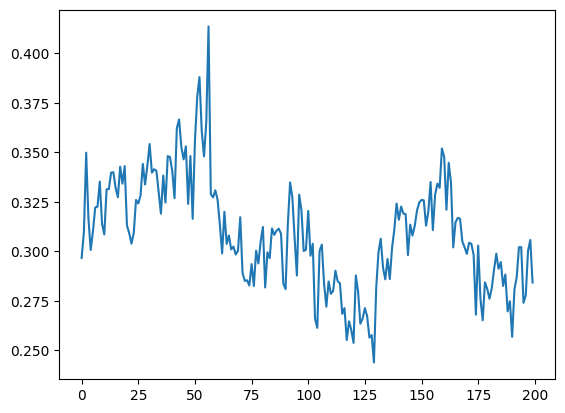

In [63]:
plot(res['omega_c'])

(0.38, 1.25)

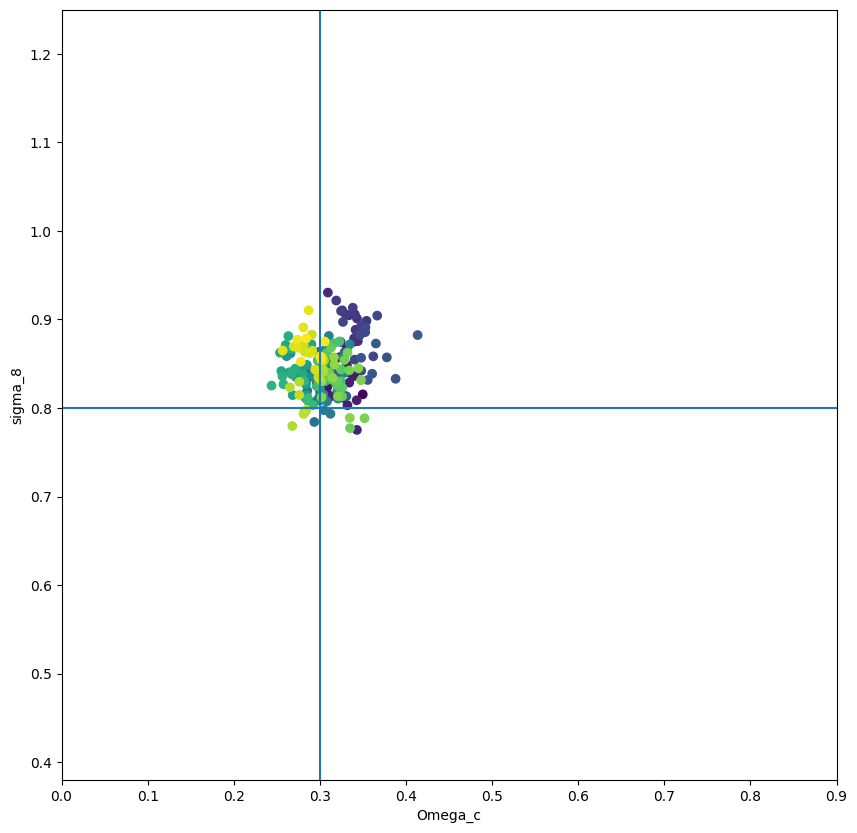

In [64]:
figure(figsize=[10,10])
scatter(res['omega_c'],
        res['sigma_8'],
        c=arange(len(res['sigma_8'])));
axvline(0.3)
axhline(0.8)
xlabel('Omega_c')
ylabel('sigma_8')
xlim(0,0.9)
ylim(0.38,1.25)

In [73]:
c = ChainConsumer()
c.add_chain({k: res[k] for k in ['omega_c', 'sigma_8']}, name = 'Posterior')

fig = c.plotter.plot(figsize="column")

TypeError: ChainConsumer.add_chain() got an unexpected keyword argument 'name'

In [75]:
res.keys()

dict_keys(['initial_conditions', 'omega_c', 'sigma_8'])

In [74]:
# Making an animation of the lensing field and density field
recs = []
for i in range(len(res['omega_c'])):
    kappa, lightcone = forward_model(res['omega_c'][i],
                                     res['sigma_8'][i],
                                     res['initial_conditions'][i])
    recs.append(kappa)

In [76]:
# The following is borrowed from https://github.com/ericjang/nf-jax/blob/master/nf-tutorial-jax.ipynb
from matplotlib import animation, rc
# from IPython.display import HTML, Image
# equivalent to rcParams['animation.html'] = 'html5'
rc('animation', html='html5')

(-0.5, 255.5, 63.5, -0.5)

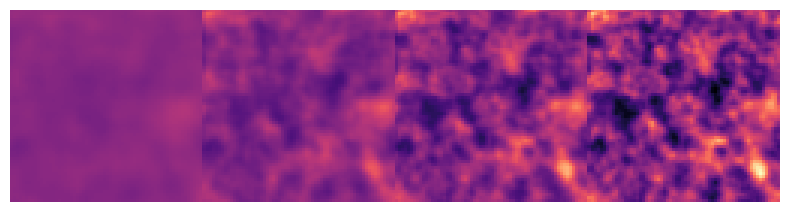

In [77]:
# First set up the figure, the axis, and the plot element we want to animate
fig, ax = subplots(figsize=(10,2.5))

paths = ax.imshow(stack(recs[0]).reshape([4*64,64]).T, cmap='magma')
axis('off')

In [78]:
def animate(inds):
  paths.set_data(stack(recs[inds*2]).reshape([4*64,64]).T)
  return (paths,)

In [80]:
anim = animation.FuncAnimation(fig, animate, frames=100, interval=100, blit=False)

In [81]:
anim

In [ ]:
# Saving the trace
import pickle

with open('lensing_fwd_mdl_nbody.pickle', 'wb') as handle:
    pickle.dump(res, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
from google.colab import files
files.download('lensing_fwd_mdl_nbody.pickle')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>